In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#import pysal as ps # Wczytanie danych z pliku dbf

# 1 Generowanie zbioru danych
Na początku wygenerujemy przykładowe dane. Do tego celu wykorzystamy funkcję *make_blobs* należącą do pakietu *sklearn.datasets*. 
Dane, które wygenerujemy będą posiadały 500 próbek reprezentowanych przez 2 cechy skupione wokół 4 obszarów (centroidów).  

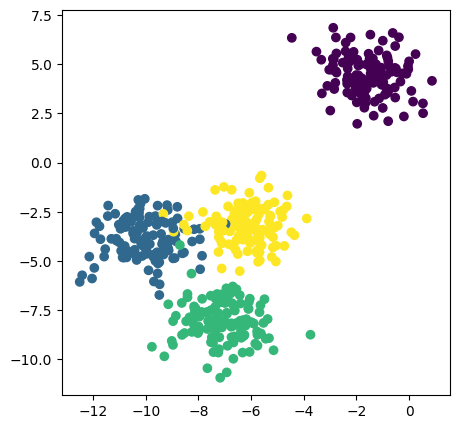

In [47]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
# Możemy przekształcić nasz zbiór zmiennych opisujących X1 i odpowiadających im klas y1 do jednej macierzy danych (pd.DataFrame)
columns = ['feature' + str(x) for x in np.arange(1, X1.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X1.T)}
d['label'] = y1
dane1 = pd.DataFrame(d).reindex(columns=columns+['label'])

# Wyświelenie
plt.figure(figsize=(5,5))
plt.scatter(dane1.feature1, dane1.feature2, marker='o', c=dane1.label)

Dane wygenerowane przez powyższy kod zostały zapamiętane w jednej macierzy danych posiadającej wartości atrybutów opisujących w kolumnach **feature1**, **feature2** oraz kolumnie **label** z wartościami atrybutu opisywanego (decyzyjnego). Zbiór składa się z 500 obiektów należących do 4 klas. 

#### Zadanie 1.1 
Należy kilka razy wygenerować zbiór danych X2, y2 z *random_state* ustawionym na *None*.

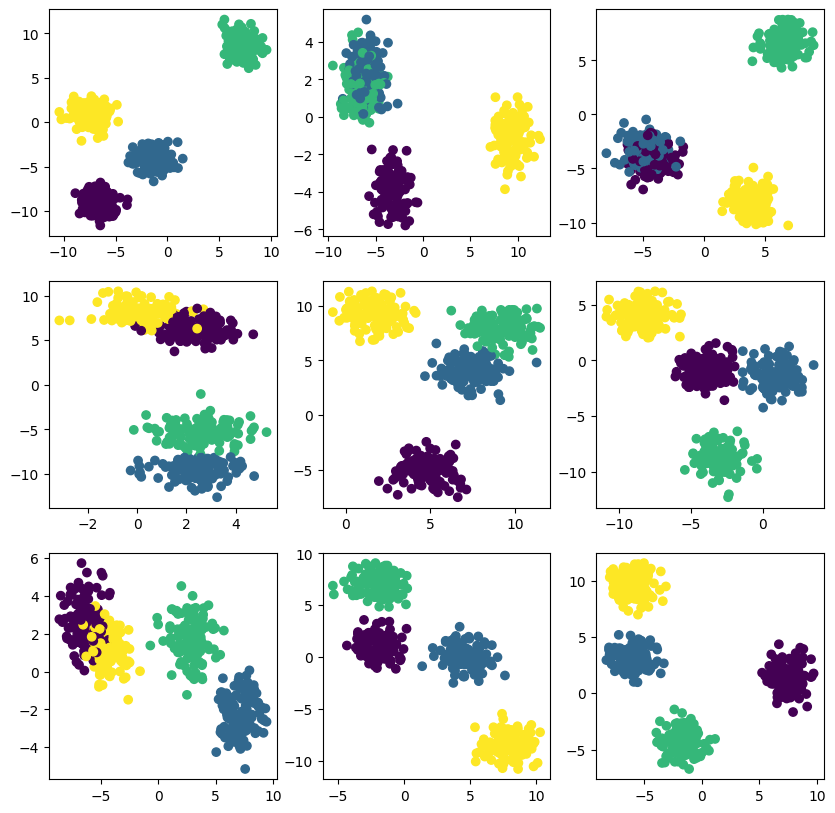

In [48]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
for x in range(9):
    x2, y2 = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=None) 
    columns = ['feature' + str(x) for x in np.arange(1, x2.shape[1]+1, 1)]
    d = {key: values for key, values in zip(columns, x2.T)}
    d['label'] = y2
    dane1 = pd.DataFrame(d).reindex(columns=columns+['label'])

    axes[int(x//3)][x%3].scatter(dane1.feature1, dane1.feature2, marker='o', c=dane1.label)

## 2 Klasyfikacja

Klasyfikacja zalicza się do metod uczenia nadzorowanego (ang. supervised learning). Zbiór (macierz) danych w tym przypadku składa się z obiektów charakteryzujących się atrybutami opisującymi i atrybutem decyzyjnym. Przyjmuje się przy tym, że pomiędzy atrybutami opisującymi a atrybutem decyzyjnym zachodzi pewien związek przyczynowo-skutkowy, zaś kategoryczny atrybut decyzyjny określa klasę, do której przynależy obiekt. Zbiór danych jest traktowany jako źródło wiedzy na podstawie którego określa się rodzaj klasyfikatora, a następnie dobiera jego parametry w tzw. procesie uczenia. Gotowy klasyfikator może następnie zostać wykorzystany do określenia przynależności obiektu, dla którego znane są jedynie wartości atrybutów opisujących do właściwej klasy. 

Z reguły w celu sprawdzenia poprawności danego algorytmu i sprawdzenia jego skuteczności dla danego zadania klasyfikacji podział zbioru danych wykonywany jest na zbiór uczący i testowy (najczęściej w proporcjach 80/20 lub 70/30). Czasem jednak w przypadku testowania algorytmów i ich dostrajania stosuje się podział 60/20/20, a poszczególne części stanowią odpowiednio zbiory: treningowy, walidacyjny i testowy. 

W rozdziale tym skupimy się na następujących metodach klasyfikacji:
1. Metoda najbliżego sąsiada (k-NN)
2. Naiwnym klasyfikatorze Bayesa
3. SVM
4. Drzewach decyzyjnych

Na końcu zaprezentowane zostaną metody łączenia/wzmacniania wyników różnych klasyfikatorów (tzw. ensemblingu), w celu poprawy jakości klasyfikacji.

### 2.1 Metoda najbliżego sąsiada (k-NN)

Zasadą działania tej metody jest poszukiwanie najbliższego sąsiada/sąsiadów dla obiektu o nieznanej klasie, wśród obiektów znajdujących się w zbiorze uczącym. Następnie, na podstawie znanych wartości atrybutów decyzyjnych najbliższych sąsiadów określana jest klasa, do której przyporządkowywany jest rozpatrywany obiekt. Najczęściej stosowanymi metrykami odległości są odległość Euklidesowa (w przypadku atrybutów ilościowych) lub Hamminga (w przypadku atrybutów kategorycznych). 

Funkcja *NearestNeighbors* tworzy kolejkę najbliższych sąsiadów. Parametr *n_neighbors* mówi o długości kolejki, w związku z czym, jeśli dla każdej próbki chcemy znaleźć jednego sąsiada należy ten parametr ustawić na **2**. 

Pierwszy przykład pokazuje poszukiwania najbliższych sąsiadów w obrębie tego samego zbioru obiektów. Dla każdego obiektu wyszukiwany jest obiekt jemu najbliższy. 

In [49]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
nbrs.fit(dane1[['feature1','feature2']])
distances, indices = nbrs.kneighbors(dane1[['feature1','feature2']])

In [50]:
nbrs_wynik = pd.DataFrame({'Prob_1': indices[:,0],
                           'Prob_2': indices[:,1],
                           'Prob_3': indices[:,2],
                           'Odlegosc_Prob1_od_1_sasiada': distances[:,1],
                           'Odlegosc_Prob1_od_2_sasiada': distances[:,2]}, 
                            columns=['Prob_1','Prob_2','Prob_3','Odlegosc_Prob1_od_1_sasiada','Odlegosc_Prob1_od_2_sasiada'])

#### Zadanie 2.1
Proszę sprawdzić czy jeśli próbka s2 z Prob_2 jest najbliższym sąsiadem odpowiedniej próbki s1 z Prob_1, to czy próbka s1 będzie najbliższym sąsiadem próbki s2.

In [51]:
nbrs_wynik[nbrs_wynik.iloc[:,3] < nbrs_wynik.iloc[:,4]]


,Prob_1,Prob_2,Prob_3,Odlegosc_Prob1_od_1_sasiada,Odlegosc_Prob1_od_2_sasiada
0,0,124,83,0.201430,0.265514
1,1,426,63,0.033245,0.115906
2,2,248,437,0.210078,0.219523
3,3,137,422,0.697796,0.798758
4,4,453,235,0.126413,0.242142
...,...,...,...,...,...
495,495,435,125,0.062478,0.136417
496,496,98,112,0.108124,0.190088
497,497,367,144,0.063313,0.308644
498,498,405,7,0.049143,0.142079


#### Zadanie 2.2
Następnie sprawdźmy ilość klas naszego zbioru 1 (macierz y1). Do tego celu użyj funkcję *np.unique*

In [52]:
np.unique(y1)
print(y1)

[2 2 1 0 3 0 3 3 1 3 2 2 3 0 3 2 1 2 0 3 1 1 3 0 3 3 0 0 1 3 2 0 3 2 3 2 1
 1 2 1 3 1 0 3 3 2 1 3 0 0 0 1 1 3 2 1 1 1 1 3 0 0 1 3 0 3 2 3 1 1 2 1 3 2
 3 3 2 3 3 1 0 0 1 0 0 1 1 0 1 1 0 2 1 3 0 2 2 3 2 0 0 2 0 1 0 3 3 0 0 1 3
 2 0 1 0 1 0 3 0 3 1 2 2 1 3 1 0 2 2 3 0 1 1 1 1 2 0 3 0 0 3 2 3 0 0 0 3 3
 2 2 1 1 0 2 0 1 1 1 1 1 1 1 1 1 0 2 2 2 3 0 2 1 3 2 0 1 1 1 1 2 3 1 0 2 2
 1 3 2 2 3 0 0 2 2 3 0 3 2 2 0 2 1 0 3 3 2 3 1 2 3 1 3 1 2 3 3 3 0 1 0 3 2
 1 3 1 1 1 0 3 0 2 1 2 1 0 0 1 2 0 2 3 1 2 2 2 2 3 1 2 1 3 0 0 3 3 0 1 3 1
 0 3 0 1 1 0 3 2 2 1 1 1 3 0 0 3 0 1 2 0 2 0 2 2 0 2 0 0 3 1 1 1 3 3 3 2 0
 2 1 2 3 2 3 2 1 2 2 1 2 2 1 0 2 3 3 0 0 3 2 0 0 3 2 0 0 3 1 0 1 3 2 2 0 1
 2 3 0 0 3 3 1 2 3 0 0 1 0 0 0 0 2 2 3 0 1 3 2 0 1 0 3 0 1 3 1 0 3 3 2 0 2
 2 2 2 2 2 1 2 0 2 0 0 1 0 3 1 2 2 0 1 0 3 2 3 1 2 1 1 0 0 2 1 3 0 3 3 2 2
 3 2 1 1 2 1 2 1 0 2 0 1 3 0 1 3 0 2 3 0 0 1 3 1 3 2 0 2 3 0 2 2 2 1 0 3 2
 3 3 1 1 2 3 3 3 3 3 3 2 3 1 2 3 0 3 0 3 1 3 0 0 0 1 3 1 2 1 0 3 2 0 2 0 2
 3 0 0 2 1 3 2 1 1 1 2 3 

Podzielmy nasz zbiór na dane treningowe i testowe.

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dane1.iloc[:,0:2], dane1.label, test_size=0.2, random_state=1)
print('Dlugosc X_train: ', len(X_train))
print('Dlugosc X_test: ', len(X_test))
print('Dlugosc y_train: ', len(y_train))
print('Dlugosc y_test: ', len(y_test))

Dlugosc X_train:  400
Dlugosc X_test:  100
Dlugosc y_train:  400
Dlugosc y_test:  100


Następnie nauczymy klasyfikator najbliższego sąsiada przy pomocy danych treningowych. Do tego celu wykorzystamy funkcję *KNeighborsClassifier*. W jej przypadku parametr *n_neighbors* określa illość sąsiadów. 

In [54]:
from sklearn.neighbors import KNeighborsClassifier
model_1nn = KNeighborsClassifier(n_neighbors=1, algorithm='auto')
model_1nn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

Wykonajmy predykcję dla zbioru X_test:

In [55]:
y_pred = model_1nn.predict(X_test)

In [56]:
model_1nn.predict(X_test)

array([3, 1, 3, 1, 0, 0, 0, 0, 2, 3, 2, 1, 1, 3, 0, 2, 2, 2, 3, 0, 0, 2,
       0, 3, 1, 2, 1, 2, 1, 0, 1, 0, 3, 0, 0, 0, 2, 1, 0, 3, 2, 0, 1, 0,
       2, 0, 0, 0, 2, 3, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 0, 1, 3, 0,
       3, 3, 3, 0, 2, 3, 3, 3, 1, 2, 2, 0, 3, 3, 0, 0, 0, 0, 3, 1, 3, 1,
       0, 0, 1, 3, 1, 3, 2, 1, 3, 2, 0, 2])

#### Zadanie 2.3

W jaki sposób możemy wyznaczyć jakość (skuteczność) klasyfikacji? Napisz stosowny program. 

In [57]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Poprawne jest {accuracy:.2f}% przewidywań")

Poprawne jest 100.00% przewidywań


Wygenerujemy teraz nowy zbiór z klastrami bardziej nakładającymi się.

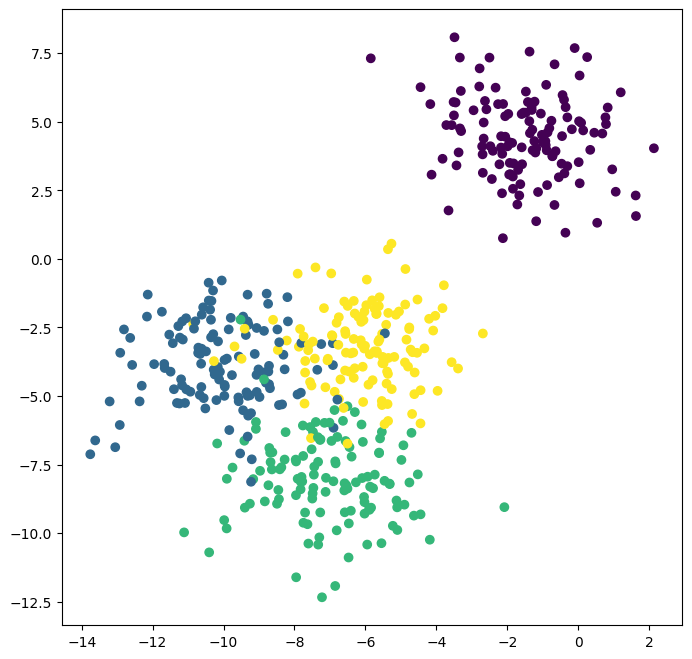

In [58]:
from sklearn.datasets import make_blobs
X3, y3 = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
columns = ['feature' + str(x) for x in np.arange(1, X3.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X3.T)}
d['label'] = y3
dane3 = pd.DataFrame(d).reindex(columns=columns+['label'])

#Wyświelenie blobów
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(dane3.feature1, dane3.feature2, marker='o', c=dane3.label)

Wyświetlimy teraz obszary dezycyjności w zależności od ilości sąsiadów

c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


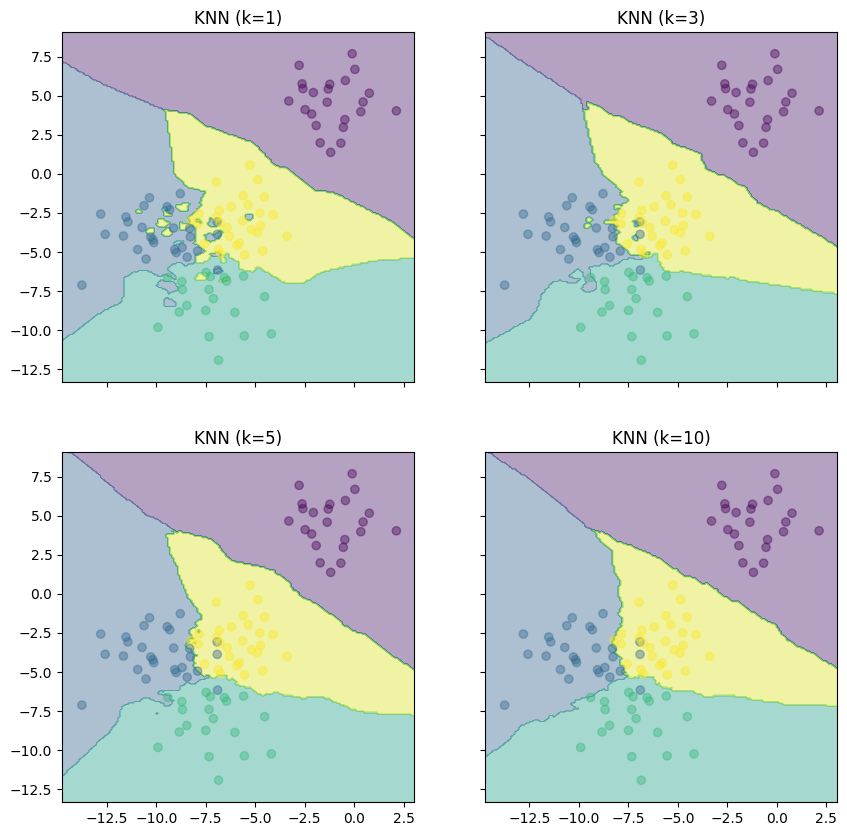

In [59]:
from itertools import product
cechy = ['feature1','feature2']

from sklearn.neighbors import KNeighborsClassifier
model_1nn = KNeighborsClassifier(n_neighbors=1)
model_1nn.fit(dane3[cechy], dane3.label)
model_3nn = KNeighborsClassifier(n_neighbors=3)
model_3nn.fit(dane3[cechy], dane3.label)
model_5nn = KNeighborsClassifier(n_neighbors=5)
model_5nn.fit(dane3[cechy], dane3.label)
model_10nn = KNeighborsClassifier(n_neighbors=10)
model_10nn.fit(dane3[cechy], dane3.label)



# Wyświetlenie obszarów decyzyjności
x_min, x_max = dane3.iloc[:, 0].min() - 1, dane3.iloc[:, 0].max() + 1
y_min, y_max = dane3.iloc[:, 1].min() - 1, dane3.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [model_1nn, model_3nn, model_5nn, model_10nn],
                        ['KNN (k=1)', 'KNN (k=3)',
                         'KNN (k=5)', 'KNN (k=10)']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(dane3.iloc[0:100, 0], dane3.iloc[0:100, 1], c=dane3.label[0:100], alpha=0.4)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### 2.2 Dobór ilości sąsiadów
W celu doboru właściwej ilości sąsiadów należy wykonać analizę błędu klasyfikacji dla różnych wartości sąsiadów.

Text(0, 0.5, 'Prawdopodobienstwo bledu')

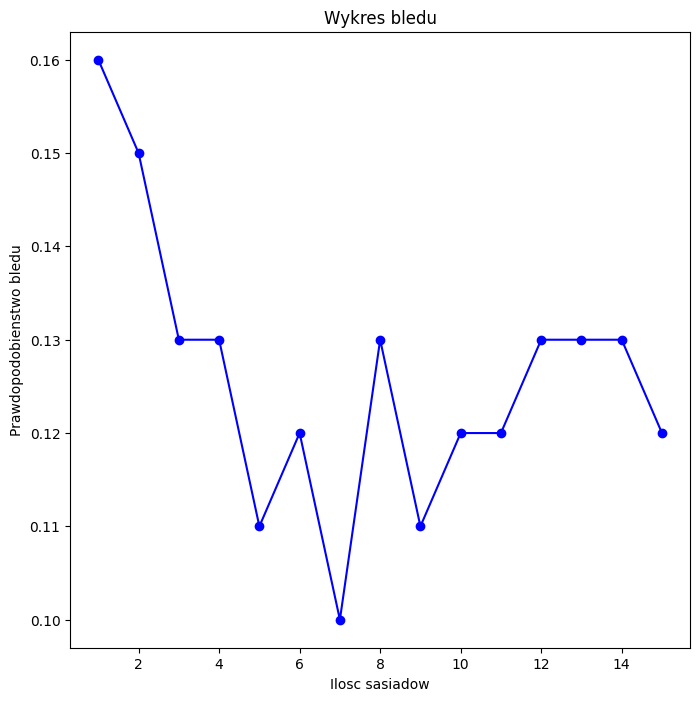

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

X3_train, X3_test, y3_train, y3_test = train_test_split(dane3[cechy], dane3['label'], test_size=0.2, random_state=1)

kvals = range(1, 16)
rss_all = np.zeros(15)
for k in kvals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X3_train,y3_train)
    predictions = model.predict(X3_test)
    rss_all[k-1] = 1-model.score(X3_test,y3_test)
plt.figure(figsize=(8,8))
plt.plot(kvals, rss_all,'bo-')
plt.title('Wykres bledu')
plt.xlabel('Ilosc sasiadow')
plt.ylabel('Prawdopodobienstwo bledu')

#### Zadanie 2.4 
Korzystając z powyższego wykresu, ilu sąsiadów należy użyć do modelu?

Należy użyć 7 sąsiadów, dla tego wyniku najniższe jest prawdopodobieństwo błędu.

Poniżej zaprezentowany został sposób automatycznego doboru liczby sąsiadów przy pomocy metody *n-krotnej* walidacji krzyżowej.

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

nKrotnosc = 5
numNeighbors  = np.arange(2,20)
param_grid    = dict(n_neighbors=numNeighbors)
grid = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=nKrotnosc)
grid.fit(dane3[cechy],dane3['label']) # W tym wypadku używamy całego zbioru. 
                # Funkcja sama dokonuje wielokrotnego 
                # podziału na zbiór uczący i testowy.
print("Najlepszy parametr: ", grid.best_params_)
print("Średni błąd klasyfikacji dla najlepszego parametru: ", 1-grid.best_score_)

Najlepszy parametr:  {'n_neighbors': np.int64(12)}
Średni błąd klasyfikacji dla najlepszego parametru:  0.061999999999999944


#### Zadanie 2.5
Przy pomocy zbioru treningowym X3 należy nauczyć model dla parametru wybranego w poprzednim zadaniu. Po nauczeniu należy dokonać predykcji wyników dla zbioru testowego X3. Następnie wyświetlony zostanie raport klasyfikacji. W raporcie tym otrzymujemy 3 podstawowe miary: prezycję (ang. precision), czułość (ang. recall) i miarę $f_1 = 2*\frac{precyzja * czułość}{precyzja+czułość}$. 

* Precyzja jest miarą wskazującą z jaką pewnością możemy ufać przewidywaniom pozytywnym: $precyzja = \frac{TP}{TP+FP}$  


* Czułość jest miarą wskazującą w jakim procencie klasa faktycznie pozytywna została pokryta przewidywaniem pozytywnym: $czułość = \frac{TP}{TP+FN}$ 

Dodatkowo wyświetlimy macierz pewności prezentującą, do której klasy zostały zaklasyfikowane obserwacje danych klas.

In [ ]:
# Uczenie najlepszego modelu (12-sąsiadów) na zbiorze treningowym X3:
knn_model = KNeighborsClassifier(n_neighbors=12)
knn_model.fit(X3_train, y3_train)
knn_prediction = knn_model.predict(X3_test)

from sklearn import metrics
# Wyświetlenie raportu klasyfikacji oraz macierzy pewności:
print("Raport klasyfikacji: ")
print(metrics.classification_report(y3_test, knn_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y3_test, knn_prediction))

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.65      0.85      0.73        13
           2       0.87      0.90      0.89        30
           3       0.90      0.77      0.83        35

    accuracy                           0.87       100
   macro avg       0.85      0.88      0.86       100
weighted avg       0.88      0.87      0.87       100

Macierz pewnosci: 
[[22  0  0  0]
 [ 0 11  0  2]
 [ 0  2 27  1]
 [ 0  4  4 27]]


### 2.3 Naiwny klasyfikator Bayesa

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
gnb = GaussianNB()
y_pred = gnb.fit(X3_train, y3_train).predict(X3_test)
# Podsumowanie wyuczenia modelu
print("Błąd klasyfikacji:", 1-gnb.score(X3_test,y3_test))
print("Raport klasyfikacji: ")
print(metrics.classification_report(y3_test, y_pred))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y3_test, y_pred))

Błąd klasyfikacji: 0.13
Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.65      0.85      0.73        13
           2       0.87      0.90      0.89        30
           3       0.90      0.77      0.83        35

    accuracy                           0.87       100
   macro avg       0.85      0.88      0.86       100
weighted avg       0.88      0.87      0.87       100

Macierz pewnosci: 
[[22  0  0  0]
 [ 0 11  0  2]
 [ 0  2 27  1]
 [ 0  4  4 27]]


In [68]:
y_pred

array([2, 2, 3, 3, 0, 1, 0, 0, 1, 0, 0, 3, 3, 2, 2, 2, 2, 3, 3, 3, 1, 3,
       2, 3, 3, 2, 3, 0, 2, 1, 2, 1, 1, 2, 0, 2, 2, 1, 3, 1, 0, 1, 0, 2,
       2, 2, 0, 2, 2, 0, 0, 3, 0, 3, 3, 1, 2, 1, 2, 2, 0, 1, 1, 3, 1, 0,
       0, 3, 2, 1, 0, 2, 3, 3, 0, 3, 1, 3, 3, 2, 3, 3, 2, 0, 3, 3, 3, 0,
       2, 2, 0, 2, 0, 3, 3, 2, 2, 1, 2, 3])

c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


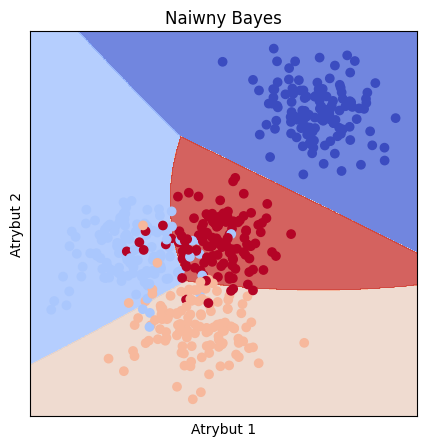

In [69]:
h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = dane3.iloc[:, 0].min() - 1, dane3.iloc[:, 0].max() + 1
y_min, y_max = dane3.iloc[:, 1].min() - 1, dane3.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
#titles = ['Naiwny Bayes']

plt.figure(figsize=(5,5))
#for i, clf in enumerate(gnb):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    #plt.subplot(1, 1, i + 1)
    #plt.subplots_adjust(wspace=0.4, hspace=0.4)

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
plt.scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3['label'], cmap=plt.cm.coolwarm)
plt.xlabel('Atrybut 1')
plt.ylabel('Atrybut 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Naiwny Bayes')

plt.show()

#### Zadanie 2.5
Porównaj otrzymane wyniki z modelem kNN dla 12 sąsiadów.

Text(0.5, 1.0, 'Naiwny Bayes')

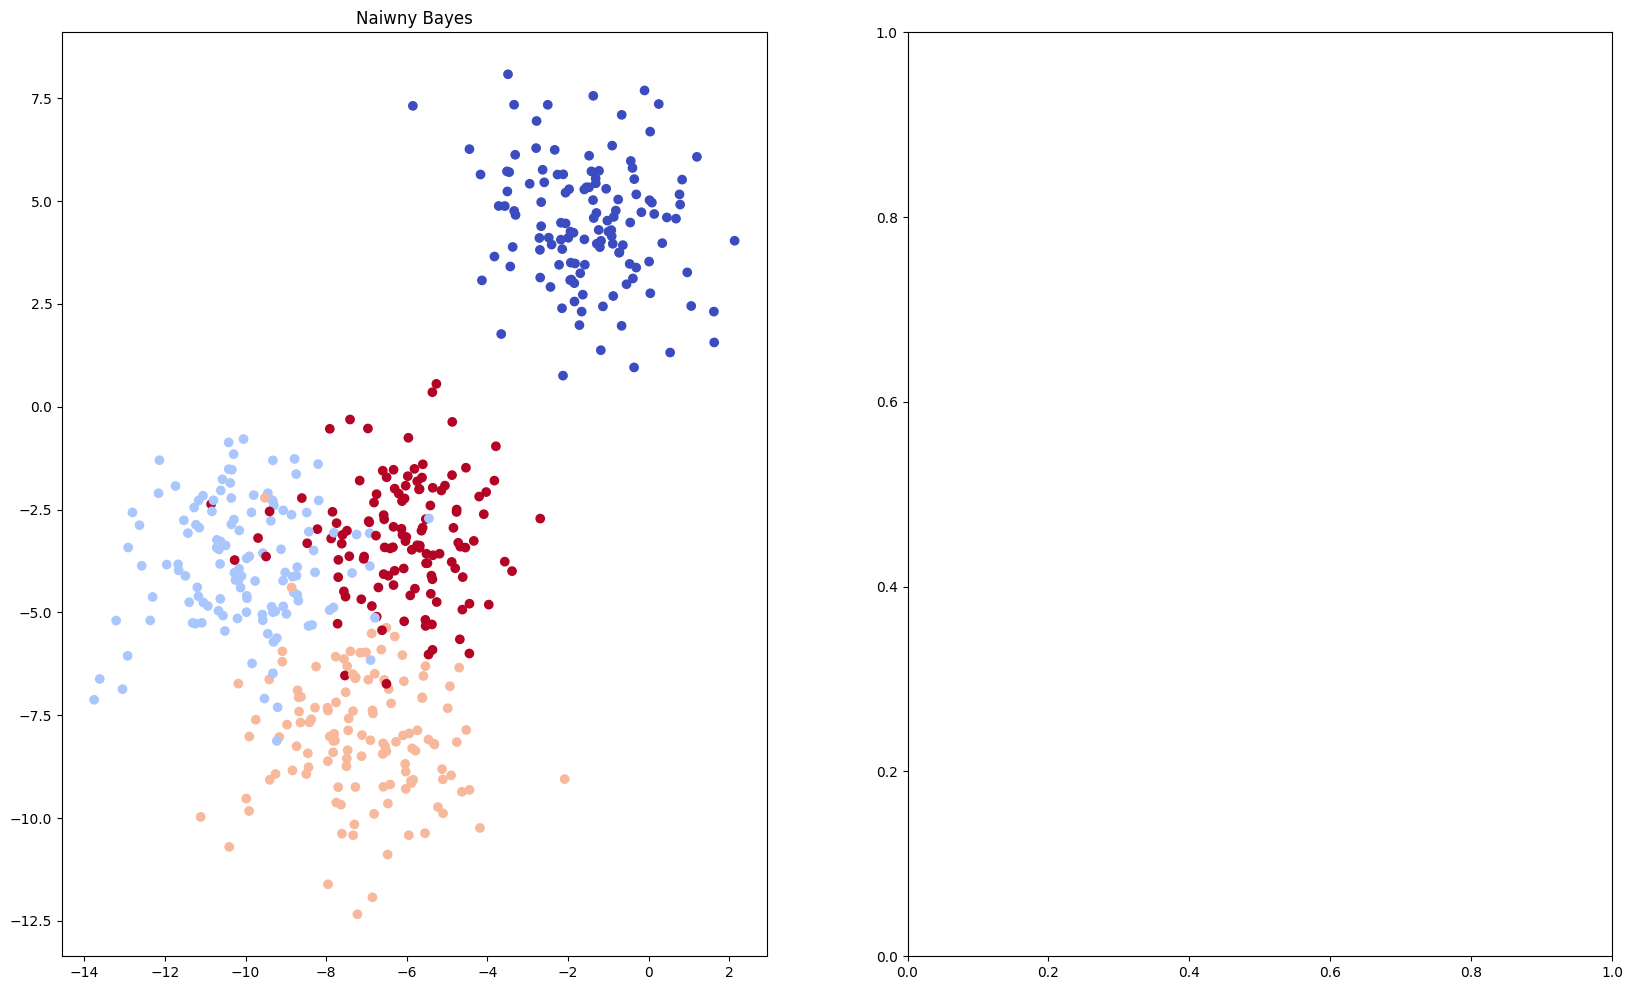

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,12))
axes[0].scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3['label'], cmap=plt.cm.coolwarm)
axes[0].set_title('Naiwny Bayes')
axes

### 2.4 SVM
Metoda wektorów nośnych/podpierających (SVM z ang. Support Vector Machine) jest algorytmem, którego zadaniem jest podzielenie przestrzeni cech przy pomocy wektorów nośnych. W przypadku 2 cech, które można zobrazować na wykresie płaskim, są to proste (w przypadku jądra liniowego), wielomiany lub funkcja Gaussa (w przypadku jąder nieliniowych). Jądra liniowe są szybkie i proste w użyciu, jednakże nadają się do klasyfikacji obszarów wyraźnie od siebie odstających. W celu dokładnego wyodrębnienia obszarów należy użyć jąder nieliniowych, uważając na przeuczenie klasyfikatora.   

In [ ]:
from sklearn import svm
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(dane3[cechy], dane3['label'])
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(dane3[cechy], dane3['label'])
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(dane3[cechy], dane3['label'])
lin_svc = svm.LinearSVC(C=C).fit(dane3[cechy], dane3['label'])

# create a mesh to plot in
x_min, x_max = dane3.iloc[:, 0].min() - 1, dane3.iloc[:, 0].max() + 1
y_min, y_max = dane3.iloc[:, 1].min() - 1, dane3.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVM z jadrem liniowym',
          'LinearSVC (jadro liniowe)',
          'SVM z jadrem RBF',
          'SVM z jadrem wielomianowym (stopnia 3)']

plt.figure(figsize=(10,10))
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3.label, cmap=plt.cm.coolwarm)
    plt.xlabel('Atrybut 1')
    plt.ylabel('Atrybut 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

### 2.5 Drzewa decyzyjne
Drzewa decyzyjne są jednymi z najpopularniejszych klasyfikatorów. Posiadają jednak pewne ograniczenie. Do procesu uczenia wymagają symetrycznego rozkładu klas. W przypadku dużej liczności zbiorów, ze zbioru uczącego wybieramy klasę najmniej liczną i z pozostałych próbek losujemy tyle samo próbek uczących. W przypadku małej liczności najmniejszych klas, możemy je posklejać w celu nauczenia klasyfikatora wyszukiwania najliczniejszych klas, a następnie używamy kolejnego drzewa, do rozdzielenia sklejonego zbioru. 

W przypadku drzew decyzyjnych złożoność modelu określana jest poprzez głębokość drzew. W rozdziale tym przeanalizujemy obszary klasyfikacji w zależności od głębokości drzewa decyzyjnego.

In [ ]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier(max_depth=4)
y_pred = tree_model.fit(X3_train, y3_train).predict(X3_test)
print("Błąd klasyfikacji:", 1-tree_model.score(X3_test,y3_test))
print("Prawdopodobieństwo przynależności do klasy: ")
print(tree_model.predict_proba(X3_test))

In [ ]:
#należy doinstalować pakiet graphviz
with open("drzewo.dot", 'w') as f:
    f = tree.export_graphviz(tree_model, out_file=f)
# dot -Tpdf drzewo.dot -o drzewo.pdf

### Wykres przestrzeni decyzyjnej dla drzew o różnej głębokości

In [ ]:
# Plot the decision boundary

tree_model_2 = tree.DecisionTreeClassifier(max_depth=2)
tree_model_2.fit(dane3[cechy],dane3['label'])
tree_model_4 = tree.DecisionTreeClassifier(max_depth=4)
tree_model_4.fit(dane3[cechy],dane3['label'])
tree_model_6 = tree.DecisionTreeClassifier(max_depth=6)
tree_model_6.fit(dane3[cechy],dane3['label'])
tree_model_10 = tree.DecisionTreeClassifier(max_depth=10)
tree_model_10.fit(dane3[cechy],dane3['label'])



# Parameters
n_classes = 4
plot_step = 0.02

x_min, x_max = dane3.iloc[:, 0].min() - 1, dane3.iloc[:, 0].max() + 1
y_min, y_max = dane3.iloc[:, 1].min() - 1, dane3.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(20, 20))

for pairidx, clf, tt in zip(product([0, 1], [0, 1]),
                        [tree_model_2, tree_model_4, tree_model_6, tree_model_10],
                        ['Drzewo decyzyjne (glebokosc = 2)', 'Drzewo decyzyjne (glebokosc = 4)',
                         'Drzewo decyzyjne (glebokosc = 6)', 'Drzewo decyzyjne (glebokosc = 10)']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[pairidx[0], pairidx[1]].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    axarr[pairidx[0], pairidx[1]].scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3['label'], cmap=plt.cm.coolwarm)
    axarr[pairidx[0], pairidx[1]].set_title(tt)
    plt.axis("tight")

plt.suptitle("Przestrzen decyzyjna dla drzew")
#plt.legend()
plt.show()

## 3 Wzmacnianie/składanie klasyfikatrów - model ensemble
Wzmacnianie klasyfikatorów jest powszechnie stosowanym podejściem uczenia maszynowego. Założeniem jest wykorzystanie wielu algorytmów uczenia w celu poprawienia ich możliwości uogólnienia/odporności w stosunku do pojednyczego modelu i zmniejszenie wariancji.

Są 3 podstawowe rodzaje składania modeli:
1. **Bagging** (Bootstrap Aggregation) - metoda ta polega na podziale zbioru treningowego na podzbiory danych. Dla każdego podzbioru buduje się klasyfikator. Następnie wyniki klasyfikacji dla danej próbki łączone są przy pomocy średniej lub większości głosowań. Bagging pozwala na zmiejszenie błędu wariancji.
2. **Boosting** - polega na sekwencyjnym uczeniu klasyfikatorów. Pierwszy klasyfikator uczony jest na całym zbiorze danych treningowych, a następny zbiór treningowy jest zbiorem wyników otrzymanych z poprzedniego klasyfikatora. Boosting posiada lepszą zdolność prognozowania od Baggingu ale posiada tendencję do nadmiernego dopasowania się do danych treningowych. Dwa najbardziej znane algoytmy to AdaBoost i Gradient Boost.
3. **Kombinacja modeli: Voting i Stacking** - polega na pracy w dwóch fazach. W pierwszej fazie wykorzystujemy wiele klasyfikatorów do przewidywania klasy. Następnie w przypadku *Votingu* dokonuje się głosowania nad klasą wynikową poprzez wybranie najczęściej występującej klasy *hard voting* albo przy użyciu prawdopodobieństwa wyniku lub poprzez zwiększenie pewność danego modelu *soft voting*. W przypadku *stackingu* wykorzystuje się kolejny klasyfikator do łączenia poszczególnych modeli w celu zmniejszenia błędu generalizacji. 

W przypadku łączenia modeli możemy wykorzystać kombinację tych samych algorytmów uczenia maszynowego ale łączenie rezultaów generowanych przez różne algorytmy daje lepsze przewidywania. Na przykad połączenie lasów losowych (połącznie drzew decyzyjnych), KNN-a i naiwnego Bayesa działa lepiej niż połączenie ze sobą trzech modeli lasów losowych. Kluczem do opracowania potężnego zestawu modeli jest ich różnorodność. 

### 3.1 Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

In [ ]:
from sklearn.datasets import make_blobs
X4, y4 = make_blobs(n_samples=1000,
                  n_features=4,
                  centers=4,
                  cluster_std=[5,4,3.5,5],
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
columns = ['feature' + str(x) for x in np.arange(1, X4.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X4.T)}


d['label'] = y4
dane4 = pd.DataFrame(d).reindex(columns=columns+['label'])

#Wyciągnięcie nazw kolumn ze zmiennymi objaśniającymi (cechami) 
cechy = dane4.columns.values
cechy = np.delete(cechy,-1)

from sklearn.model_selection import train_test_split
X4_train, X4_test, y4_train, y4_test = train_test_split(dane4[cechy], dane4['label'], test_size=0.2, random_state=1)

bagging.fit(X4_train,y4_train)

In [ ]:
# Dokonanie predykcji dla zbioru X4_test:
bagging_prediction = bagging.predict(X4_test) 
# Wyświetlenie raportu klasyfikacji oraz macierzy pewności:
from sklearn import metrics
print("Błąd klasyfikacji:", 1-bagging.score(X4_test,y4_test))
print("Raport klasyfikacji: ")
print(metrics.classification_report(y4_test, bagging_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y4_test, bagging_prediction))


In [ ]:
C = 1.0  # SVM parametr regularyzacji
svc = svm.SVC(kernel='linear', C=C).fit(X4_train, y4_train)
svc_prediction = svc.predict(X4_test)
from sklearn import metrics
print("Błąd klasyfikacji:", 1-svc.score(X4_test,y4_test))
print("Raport klasyfikacji: ")
print(metrics.classification_report(y4_test, svc_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y4_test, svc_prediction))

### 3.2 Boosting

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#Inicjalizacja modelu klasyfikatora Ada Boost
ada_boost_model = AdaBoostClassifier(n_estimators=100)
# Wyliczenie wartości błędu przy pomocy walidacji krzyżowej
scores = cross_val_score(clf, dane4[cechy], dane4.label, cv=5)
print("Średnia wartość błędu: ", 1-scores.mean()) 


In [ ]:
# Uczenie modelu przy pomocy zbioru treningowego X4 
ada_boost_model.fit(X4_train, y4_train)
ada_boost_model_prediction = ada_boost_model.predict(X4_test)
print("Błąd klasyfikacji:", 1-ada_boost_model.score(X4_test,y4_test))
print("Raport klasyfikacji: ")
print(metrics.classification_report(y4_test, ada_boost_model_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y4_test, ada_boost_model_prediction))

In [ ]:
ada_boost_model.estimators_

### 3.3 Voting
Do opracowania ensembla posłużymy się trzema klasyfikatorami:
1. Liniowym SVM-em
2. Drzewem decyzyjnym o głębokości 2
3. Naiwnym Bayesem
Nasz klasyfikator będzie klasyfikatorem głosującym z opcją 'hard'. Wybrana zostania klasa, która będzie miała przewagę głosów.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# Inicjalizacja 3 klasyfikatorów
clf1 = svm.LinearSVC(C=1)
clf2 = DecisionTreeClassifier(max_depth=2,random_state=1)
clf3 = GaussianNB()
#Inicjalizacja klasyfikatora głosującego (z opcją hard)
eclf = VotingClassifier(estimators=[('svm', clf1), ('dt', clf2), ('gnb', clf3)], voting='hard')

# Walidacja krzyżowa
for clf, label in zip([clf1, clf2, clf3, eclf], ['Linear SVM', 'Drzewo Decyzyjne', 'Naiwny Bayes', 'Ensemble']):
    scores = cross_val_score(clf, dane4[cechy], dane4['label'], cv=5, scoring='accuracy')
    print("Skuteczność: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Drugą opcją jest klasyfikator głosujący z opcją 'soft'. Wtedy do opracowania ensembla należy wykorzystać klasyfikatory, które są w stanie policzyć prawdopodobieństwo przynależności do danej klasy. Następnie klasyfikator określa przynależną klasę, biorąc pod uwagę poszczególne prawdopodobieństwa. Opcjonalnie można dołożyć wagi, które same będą wzmacniać wyniki otrzymane przez dane klasyfikatory.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Inicjalizacja klasyfikatorów
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=12)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])

clf1 = clf1.fit(X3,y3)
clf2 = clf2.fit(X3,y3)
clf3 = clf3.fit(X3,y3)
eclf = eclf.fit(X3,y3)

# Wyrysowanie obszarow decyzyjnych
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Drzewo Decyzyjne (glebokosc=4)', 'KNN (k=12)',
                         'Kernel SVM', 'Klasyfikator Glosujacy']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(dane3.iloc[:, 0], dane3.iloc[:, 1], c=dane3['label'], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

## Zadania 4
#### 4.1 Proszę pokazać jak zmieniają się obszary decyzyjne oraz błąd generalizacji modelu dla różnej głębokości drzew decyzyjnych i różnej ilości prób bootstrapowych przy wykorzystaniu baggingu.  
#### 4.2 Proszę pokazać jak zmieniają się obszary decyzyjne oraz błąd generalizacji modelu SVM o jądrze wielomianowym dla różnych stopni wielomianu i różnej ilości prób bootstrapowych przy wykorzystaniu baggingu. 
#### 4.3 Proszę pokazać jak zmieniają się obszary decyzyjne oraz błąd generalizacji klasyfikatora kNN dla różnej ilości sąsiadów i różnej ilości prób bootstrapowych przy wykorzystaniu baggingu.